# Bayesian Outlier Modeling 
## For N-of-1 Outlier Analysis of TCGA against Normal Sets

Model outliers using a linear combination of approximations. Each background dataset, $X_i$, for each gene $j$, contributes a posterior distribution of expression $y_{i,j}$ to a linear model that learns the vector of $\beta$ weights corresponding to each background comparison distribution to model an $n$-of-1 tumor sample's distribution $z_j$. Samples drawn from the posterior distribution $z_j$ are then compared to the n-of-1 sample.

# Inputs

In [27]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import time

import rnaseq_lib3 as r

In [2]:
df = pd.read_hdf('/mnt/data/Objects/tcga_gtex_tpm_norm_filt.hd5')
df.head(2)

,id,tissue,subtype,tumor,label,RP11-40C6.2,IGHG1,IGKC,KRT5,IGLC2,...,IGHEP1,RP11-44N21.4,GAPDHP61,P2RX5-TAX1BP3,RP11-408H20.3,RP13-726E6.2,CTB-43E15.1,ZNF878,OR2H2,RP4-530I15.9
GTEX-UTHO-1226-SM-3GAEE,GTEX-UTHO-1226-SM-3GAEE,Heart,Heart_Atrial_Appendage,no,gtex,0.000000,10.302941,10.712460,2.750618,7.780669,...,0.000000,0.0,0.0,0.150556,0.0,0.000000,0.0,0.070387,0.790754,0.815589
GTEX-146FH-1726-SM-5QGQ2,GTEX-146FH-1726-SM-5QGQ2,Esophagus,Esophagus_Mucosa,no,gtex,2.970847,8.778885,10.445933,12.393268,8.440056,...,0.176318,0.0,0.0,0.411426,0.0,0.176318,0.0,0.622930,0.042644,0.378503


In [3]:
drug_genes = [x.split('\t')[0] for x in open('../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]
len(drug_genes)

85

Subset by dataset

In [4]:
cols = df.columns[:5].tolist()
drug_df = df[cols + drug_genes]

gtex = df[df.label == 'gtex']
normal = df[df.label == 'tcga-normal']
tumor = df[df.label == 'tcga-tumor']

In [5]:
def plot_gene_dist(n_of_1, gene):
    plt.axvline(n_of_1[gene], label='n-of-1', color='red')
    sns.kdeplot(gtex[gene], label='gtex')
    sns.kdeplot(normal[gene], label='normal')
    sns.kdeplot(tumor[gene], label='tumor')    
    plt.title(gene);

In [8]:
def fit_genes(genes, datasets):
    fits = {}
    for gene in genes:
        for name, dataset in datasets:
            key = f'{gene}-{name}'
            fits[key] = st.norm.fit(dataset[gene])
    return fits

In [25]:
def train_linear(n_of_1, genes, datasets, fits, n_samples=200, tune=1000):
    """
    n_of_1: tumor sample 
    genes: genes to learn
    datasets: datasets to include
    fits = fits[gene-dataset] contain MAP of expression
    n_samples = Samples to learn
    """
    with pm.Model() as model:
        # Priors for linear model
        alpha = pm.Normal('alpha', 0, 5)
        beta = pm.Normal('beta', 0, 5, shape=len(datasets))
        
        # Convert fits into Normal RVs
        exp_rvs = {key: pm.Normal(key, *fits[key]) for key in fits}
        
        # Define linear model for each gene
        mu = {}
        for i, gene in enumerate(genes):
            mu[gene] = alpha
            for j, (name, _) in enumerate(datasets):
                mu[gene] += exp_rvs[f'{gene}-{name}'] * beta[j]
        
        # Single sigma across all genes
        sigma = pm.InverseGamma('sigma', 1)
        
        # Define z distributions for each mu
        z = {}
        for i, gene in enumerate(genes):
            obs = n_of_1[gene]
            z[gene] = pm.Laplace(gene, mu=mu[gene], b=sigma, observed=obs)
        
        # Calculate trace
        trace = pm.sample(n_samples, 
                          tune=tune, 
                          nuts_kwargs={'target_accept': 0.90},
                          njobs=12)
    return model, trace

In [48]:
def posterior_from_linear(trace, gene, n_of_1=n_of_1, gtex=gtex, normal=normal, ax=None):
    # Get Median of priors
    a = trace['alpha']
    b1 = trace['beta'][:,0]
    b2 = trace['beta'][:,1]
    
    N = len(a)
    
    # 1000 samples from our datasets
    gtex_samples = np.random.choice(gtex[gene], N)
    normal_samples = np.random.choice(normal[gene], N)
    
    # Calculate z based on samples
    z = a + b1 * gtex_samples + b2 * normal_samples
    
    # Calculate PPP
    z_true = n_of_1[gene]
    ppp = round(sum(z_true < z) / len(z), 2)

    # Plot
    if ax:
        ax.axvline(n_of_1[gene], color='red', label='z-true')
        ax.set_title(f'{gene} - P: {ppp}')
        sns.kdeplot(z, label='Linear-Equation', ax=ax)
    else:
        plt.axvline(n_of_1[gene], color='red', label='z-true')
        plt.title(f'{gene} - P: {ppp}')
        sns.kdeplot(z, label='Linear-Equation');

In [51]:
def posterior_predictive_pval(ppc, gene, n_of_1=n_of_1, ax=None):
    # Compute PPP
    z = ppc[gene]
    z_true = n_of_1[gene]
    ppp = sum(z_true < z) / len(z)
    
    # Plot
    if ax:
        ax.axvline(n_of_1[gene], color='red', label='z-true')
        ax.set_title(f'{gene} - P: {ppp}')
        sns.kdeplot(z, label='Posterior', ax=ax);
    else:
        plt.axvline(n_of_1[gene], color='red', label='z-true')
        plt.title(f'{gene} - P: {ppp}')
        sns.kdeplot(z, label='Posterior');

# Run Simple Model with N Genes

In [20]:
n_genes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
add_genes = ['ARAF', 'JAK2']
datasets = [('gtex', gtex), ('normal', normal)]

tumor_id = 'TCGA-KK-A7B2-01'
n_of_1 = tumor.loc[tumor_id]

In [32]:
runs = {}
for n in n_genes:
    runs[n] = {}
    # Collect genes
    runs[n]['genes'] = list(set(list(np.random.choice(df.columns[5:], n-2, replace=False)) + add_genes))
    # Get expression fits
    runs[n]['fits'] = fit_genes(runs[n]['genes'], datasets)
    # Run model
    t0 = time.time()
    model, trace = train_linear(n_of_1, runs[n]['genes'], datasets, runs[n]['fits'])
    runs[n]['time'] = time.time() - t0
    # Save model and trace
    runs[n]['model'] = model
    runs[n]['trace'] = trace

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [sigma, KCNS1-normal, KCNS1-gtex, RP11-1148L6.9-normal, RP11-1148L6.9-gtex, KCTD18-normal, KCTD18-gtex, NDE1-normal, NDE1-gtex, NQO1-normal, NQO1-gtex, PPIG-normal, PPIG-gtex, ARAF-normal, ARAF-gtex, RP11-736N17.4-normal, RP11-736N17.4-gtex, LSM10-normal, LSM10-gtex, JAK2-normal, JAK2-gtex, beta, alpha]
Sampling 12 chains: 100%|██████████| 14400/14400 [07:00<00:00,  3.41draws/s]
The number of effective samples is smaller than 25% for some parameters.
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [sigma, DAXX-normal, DAXX-gtex, GINS1-normal, GINS1-gtex, RPS16-normal, RPS16-gtex, RP11-958N24.1-normal, RP11-958N24.1-gtex, ZNF37A-normal, ZNF37A-gtex, RP11-498C9.3-normal, RP11-498C9.3-gtex, MCAM-normal, MCAM-gtex, ZNF117-normal, ZNF1

Sampling 12 chains:  85%|████████▌ | 12287/14400 [14:40<02:56, 12.00draws/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 12 chains: 100%|██████████| 14400/14400 [18:54<00:00,  1.50draws/s]
The number of effective samples is smaller than 10% for some parameters.
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [sigma, DUSP28-normal, DUSP28-gtex, PTCH2-normal, PTCH2-gtex, BEST1-normal, BEST1-gtex, IBSP-normal, IBSP-gtex, KDM5A-normal, KDM5A-gtex, ABCC6P2-normal, ABCC6P2-gtex, MDH1B-normal, MDH1B-gtex, PRAC2-normal, PRAC2-gtex, ZBED4-normal, ZBED4-gtex, ZNF689-normal, ZNF689-gtex, KBTBD2-normal, KBTBD2

Sampling 12 chains: 100%|██████████| 14400/14400 [1:24:42<00:00,  4.12s/draws]
The estimated number of effective samples is smaller than 200 for some parameters.
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [sigma, RIPPLY2-normal, RIPPLY2-gtex, RP11-395N3.1-normal, RP11-395N3.1-gtex, ZNF615-normal, ZNF615-gtex, RPL27A-normal, RPL27A-gtex, RORA-AS1-normal, RORA-AS1-gtex, CTC-457L16.2-normal, CTC-457L16.2-gtex, DNAJB3-normal, DNAJB3-gtex, RPL9-normal, RPL9-gtex, DEXI-normal, DEXI-gtex, GLTSCR1-normal, GLTSCR1-gtex, SOHLH2-normal, SOHLH2-gtex, PLEKHM2-normal, PLEKHM2-gtex, JAK2-normal, JAK2-gtex, RP11-284M14.1-normal, RP11-284M14.1-gtex, RP11-605F22.1-normal, RP11-605F22.1-gtex, AQR-normal, AQR-gtex, NLK-normal, NLK-gtex, KCNK5-normal, KCNK5-gtex, ST3GAL5-normal, ST3GAL5-gtex, CCDC154-normal, CCDC154-gtex, SNN-normal, SNN-gtex, RP11-326C3.7-normal, RP11-326C3.7-gtex, KLRAP1-normal,

## Compare Traceplots

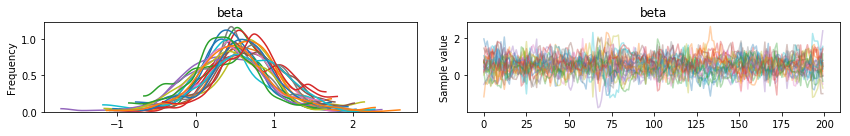

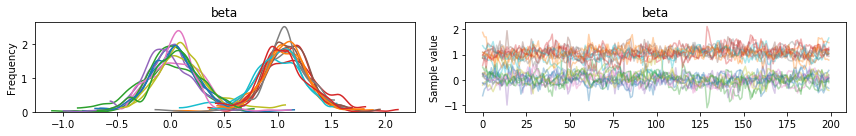

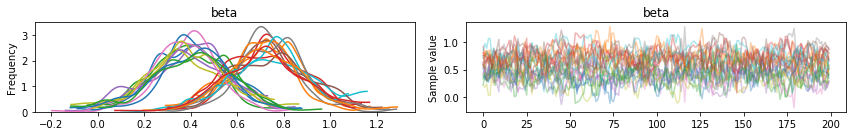

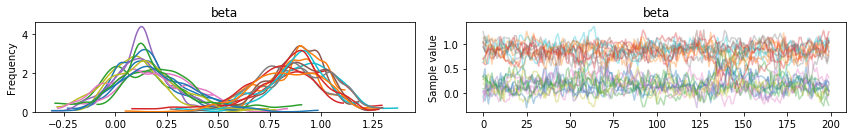

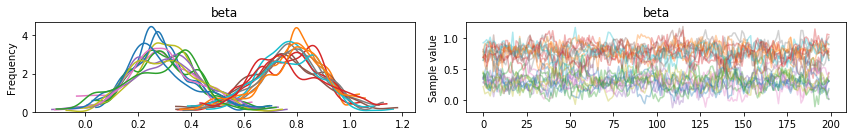

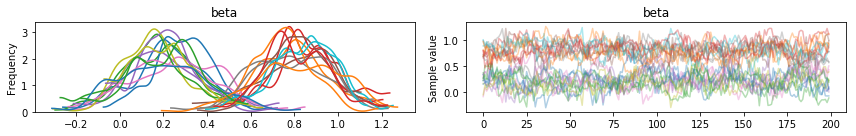

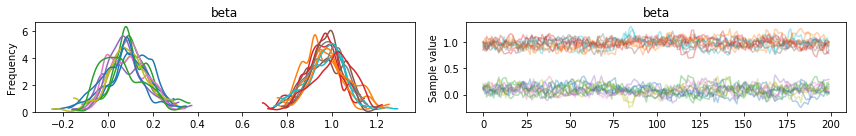

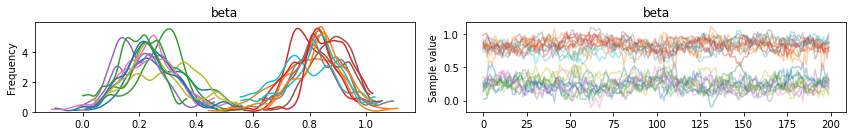

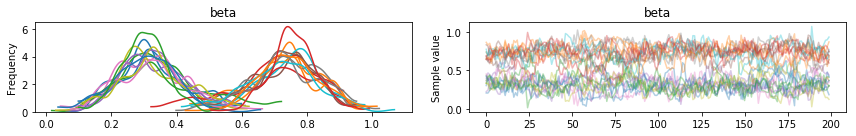

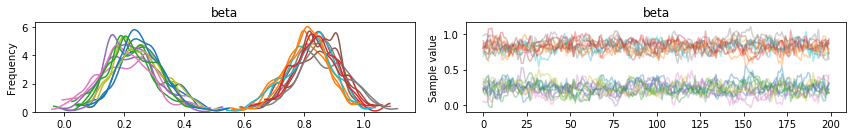

In [39]:
for i in n_genes:
    pm.traceplot(runs[i]['trace'], varnames=['beta']);

## Compare Parameter Estimates

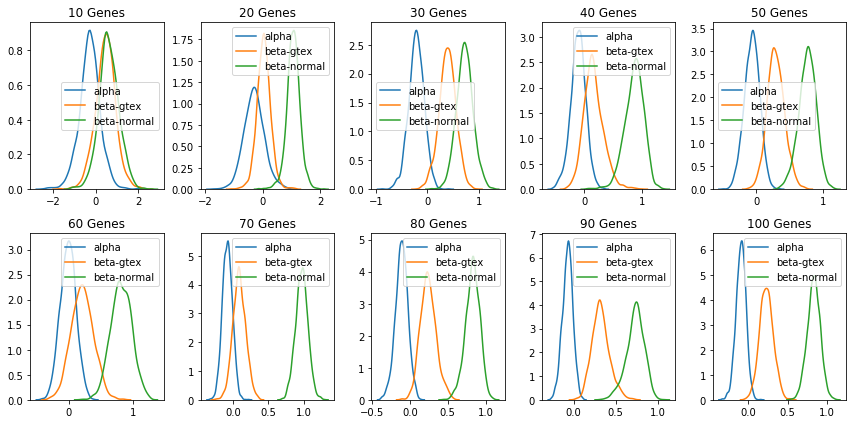

In [55]:
_, ax = plt.subplots(2, 5, figsize=(12, 6))
ax = ax.flatten()
for i, n in enumerate(n_genes):
    trace = runs[n]['trace']
    sns.kdeplot(trace['alpha'], label='alpha', ax=ax[i])
    sns.kdeplot(trace['beta'][:,0], label='beta-gtex', ax=ax[i])
    sns.kdeplot(trace['beta'][:,1], label='beta-normal', ax=ax[i])
    ax[i].set_title(f'{n} Genes')
plt.tight_layout()

## Compare Posterior from Linear Model

JAK2 which isn't an outlier

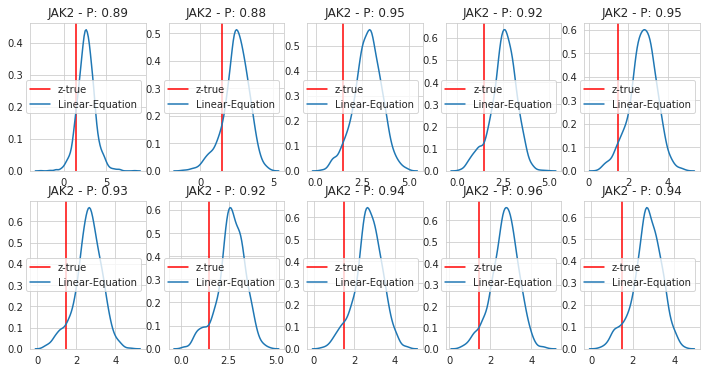

In [63]:
_, ax = plt.subplots(2, 5, figsize=(12, 6))
ax = ax.flatten()
for i, n in enumerate(n_genes):
    trace = runs[n]['trace']
    posterior_from_linear(trace, 'JAK2', ax=ax[i])

And ARAF which is an outlier

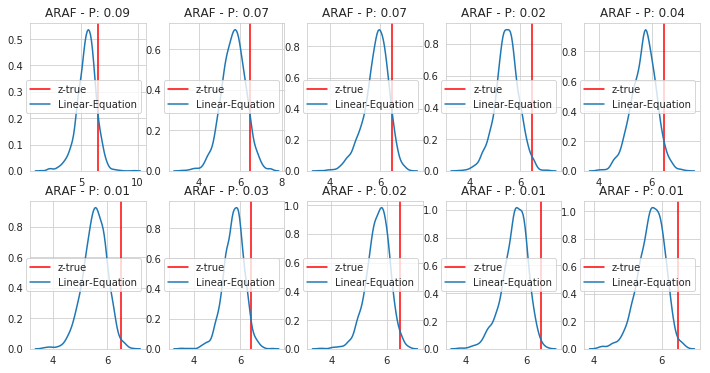

In [64]:
_, ax = plt.subplots(2, 5, figsize=(12, 6))
ax = ax.flatten()
for i, n in enumerate(n_genes):
    trace = runs[n]['trace']
    posterior_from_linear(trace, 'ARAF', ax=ax[i])

## Posterior Sampling

For JAK2, non-outlier

100%|██████████| 200/200 [00:17<00:00, 11.38it/s]


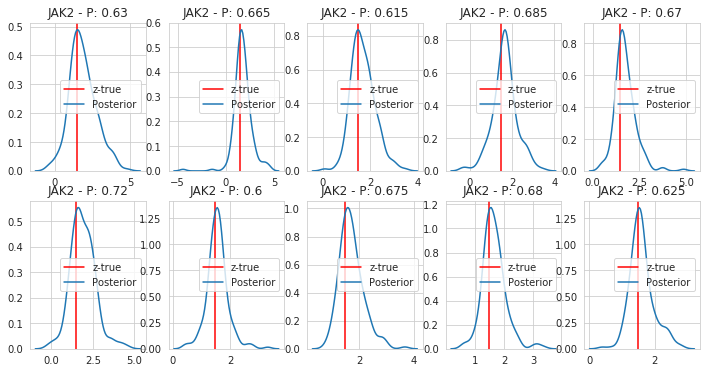

In [65]:
_, ax = plt.subplots(2, 5, figsize=(12, 6))
ax = ax.flatten()
for i, n in enumerate(n_genes):
    trace = runs[n]['trace']
    model = runs[n]['model']
    ppc = pm.sample_ppc(trace, model=model)
    posterior_predictive_pval(ppc, gene='JAK2', ax=ax[i])

For outlier ARAF

100%|██████████| 200/200 [00:16<00:00, 12.14it/s]


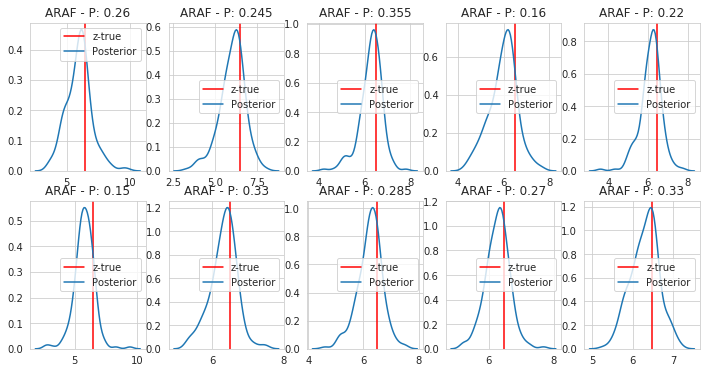

In [66]:
_, ax = plt.subplots(2, 5, figsize=(12, 6))
ax = ax.flatten()
for i, n in enumerate(n_genes):
    trace = runs[n]['trace']
    model = runs[n]['model']
    ppc = pm.sample_ppc(trace, model=model)
    posterior_predictive_pval(ppc, gene='ARAF', ax=ax[i])

## Runtimes

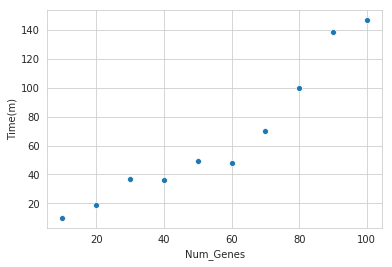

In [75]:
run_plot = pd.DataFrame([n_genes, [runs[n]['time']/60 for n in n_genes]]).T
run_plot.columns = ['Num_Genes', 'Time(m)']
sns.scatterplot(data=run_plot, x='Num_Genes', y='Time(m)');

## Conclusion

~60 genes seems an appropriate choice wrt both runtime as well as recapitulating answers when using more genes, at least when there are only 2 comparison background datasets. 